In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import PIL
import random
import math

In [22]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [23]:
# pretrained_model = "reg_H.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model_list = []
for i in range(26):
    pretrained_model = "../GoogleFonts_reg/model/reg_" + chr(i + 65) + ".pth"
    # ネットワークの初期化
    model = Net().to(device)
    # 訓練済みモデルのロード
    model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
    # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
    model.eval()
    model_list.append(model)

CUDA Available:  True


In [25]:
def test(model, device):
    R2_list = []
    for index, model in enumerate(model_list):
        class MyDataset(torch.utils.data.Dataset):

            def __init__(self, label_path, transform=None):
                x = []
                y = []
                
                with open(label_path, 'r') as infh:
                    for line in infh:
                        d = line.replace('\n', '').split('\t')
                        x.append(os.path.join(os.path.dirname(label_path), d[0]))
                        y.append(float(d[1]))
                
                self.x = x    
                self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
                
                self.transform = transform
            
            
            def __len__(self):
                return len(self.x)
            
            
            def __getitem__(self, i):
                img = PIL.Image.open(self.x[i]).convert('RGB')
                if self.transform is not None:
                    img = self.transform(img)
                
                return img, self.y[i]

        transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize((0.5,), (0.5,))])

        alphabet = chr(index + 65)
        data_dir = '../GoogleFonts_reg/' + alphabet + '/reg_' + alphabet + '_test.tsv'

        dataset = MyDataset(data_dir, transform=transform)

        dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

        a = 0
        target_total = []
        output_total = []
        count = 0
        correct = 0
        # テスト用データセット内の全てのサンプルをループします
        for data, target in tqdm(dataloader, total = 200):
            # i+=1
            # if i==150:
            #     break
            # データとラベルをデバイス（CPUもしくはGPU）に送信します
            data, target = data.to(device), target.type(torch.LongTensor).to(device)

            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
            data.requires_grad = True

            # データをモデルに順伝播させます
            output = model(data)

            # if output.item() >= 4:
            #     count += 1
            #     if target.item() >= 4:
            #         correct += 1

            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave("../GoogleFonts_reg/reg_result/" + alphabet + chr() + "/{}".format(count) + "/" + "{}.png".format(i), data.squeeze().detach().cpu().numpy(), cmap="gray")
            a += (target.item() - output.item()) ** 2
            target_total.append(target.item())
            output_total.append(output.item())
            # print("{}:{}".format(output.item(), target.item()))
        sum = np.sum(target_total)
        ave = sum / len(target_total)
        b = np.sum(list(map(lambda x: x ** 2, target_total - ave)))
        R2 = 1 - (a / b)
        print(chr(index + 65) + "_R^2:{}".format(R2))
        R2_list.append(R2)
        plt.figure(figsize=(5,5))
        x = np.array([0, 35])
        y = x
        plt.scatter(target_total, output_total, zorder=2)
        plt.plot(x, y, color = "orangered", zorder=1)
        plt.xlim(0, 35)
        plt.ylim(0, 35)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
        plt.savefig("../GoogleFonts_reg/y_y/reg_" + chr(index + 65) + ".png", facecolor="white")
        plt.show()
    df = pd.DataFrame(data=np.array([R2_list]), index=["R^2"], columns=[chr(i + 65) for i in range(26)])
    print(max)
    # df = pd.DataFrame(data=np.array([R2_list]))
    return df

100%|██████████| 200/200 [00:00<00:00, 290.55it/s]


A_R^2:0.7506023408065717


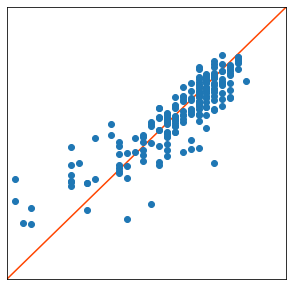

100%|██████████| 200/200 [00:00<00:00, 408.13it/s]


B_R^2:0.5370471660407148


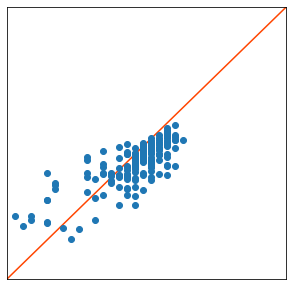

100%|██████████| 200/200 [00:00<00:00, 405.06it/s]


C_R^2:0.5812867537749837


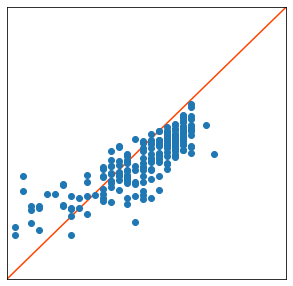

100%|██████████| 200/200 [00:00<00:00, 400.99it/s]


D_R^2:0.7077500083097421


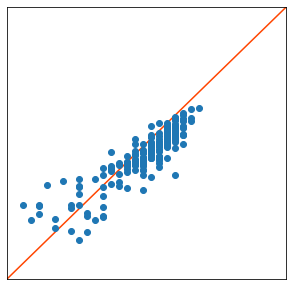

100%|██████████| 200/200 [00:00<00:00, 399.62it/s]


E_R^2:0.3174686860229904


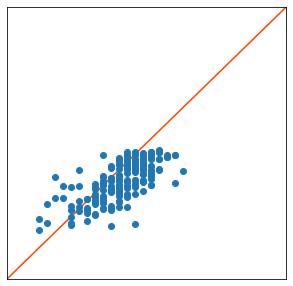

100%|██████████| 200/200 [00:00<00:00, 469.51it/s]


F_R^2:0.6188786518470397


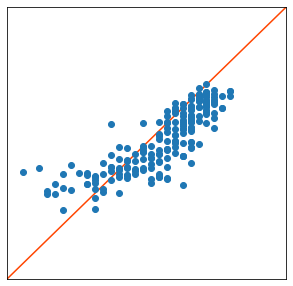

100%|██████████| 200/200 [00:00<00:00, 541.24it/s]


G_R^2:0.44159313520974264


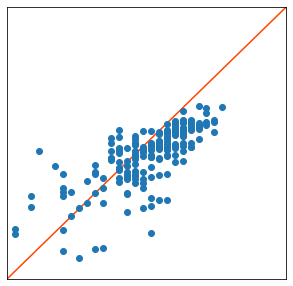

100%|██████████| 200/200 [00:00<00:00, 513.44it/s]


H_R^2:0.5824476578406175


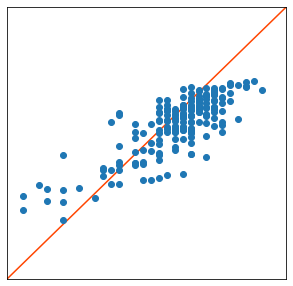

100%|██████████| 200/200 [00:00<00:00, 555.90it/s]


I_R^2:0.634477871500674


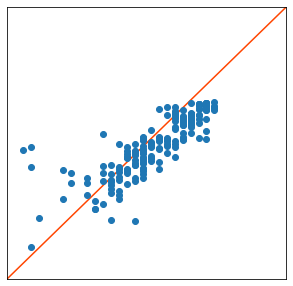

100%|██████████| 200/200 [00:00<00:00, 545.23it/s]


J_R^2:0.5712892240232312


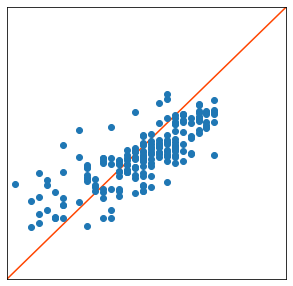

100%|██████████| 200/200 [00:00<00:00, 559.90it/s]


K_R^2:0.6276014417891738


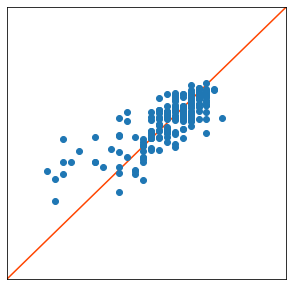

100%|██████████| 200/200 [00:00<00:00, 494.72it/s]


L_R^2:0.6304453125570133


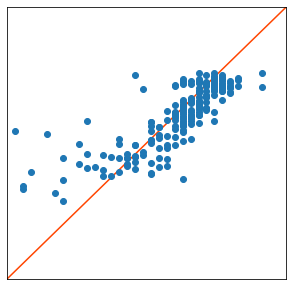

100%|██████████| 200/200 [00:00<00:00, 385.36it/s]

M_R^2:0.5145624750585154


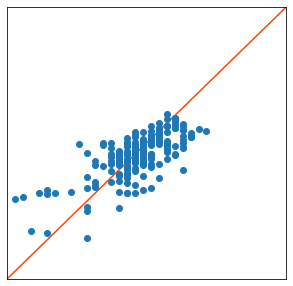

100%|██████████| 200/200 [00:00<00:00, 373.71it/s]


N_R^2:0.6020875371682769


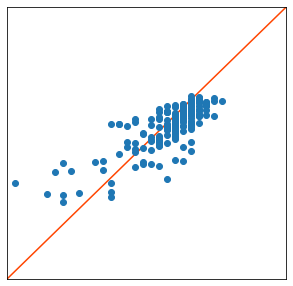

100%|██████████| 200/200 [00:00<00:00, 384.02it/s]


O_R^2:0.43043460801221656


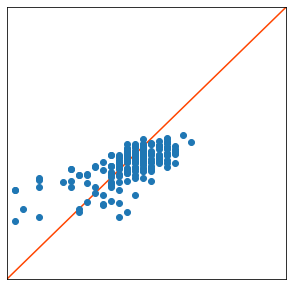

100%|██████████| 200/200 [00:00<00:00, 384.74it/s]


P_R^2:0.6254187514905567


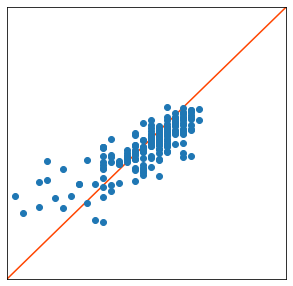

100%|██████████| 200/200 [00:00<00:00, 467.73it/s]


Q_R^2:0.810922742569891


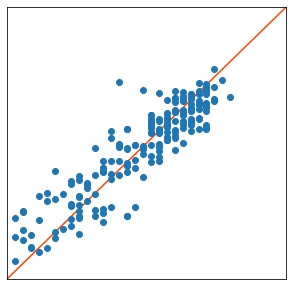

100%|██████████| 200/200 [00:00<00:00, 471.74it/s]


R_R^2:0.5933123218184498


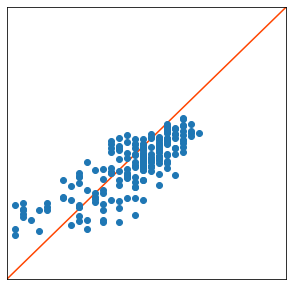

100%|██████████| 200/200 [00:00<00:00, 520.50it/s]


S_R^2:0.48266464647092233


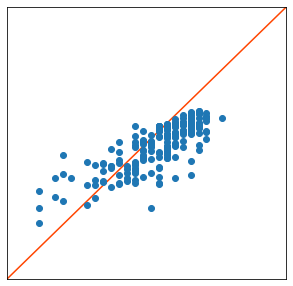

100%|██████████| 200/200 [00:00<00:00, 545.56it/s]


T_R^2:0.7496595047548367


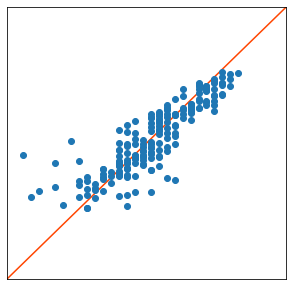

100%|██████████| 200/200 [00:00<00:00, 489.29it/s]

U_R^2:0.548613628226381


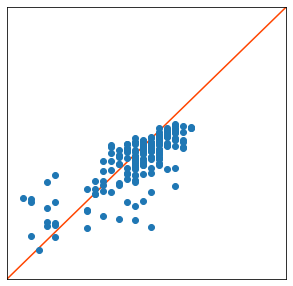

100%|██████████| 200/200 [00:00<00:00, 507.75it/s]


V_R^2:0.4191377390730089


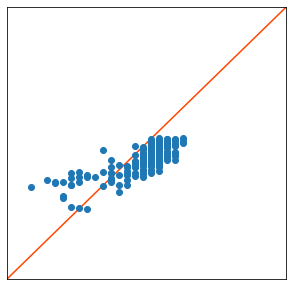

100%|██████████| 200/200 [00:00<00:00, 432.29it/s]


W_R^2:0.7471313940200726


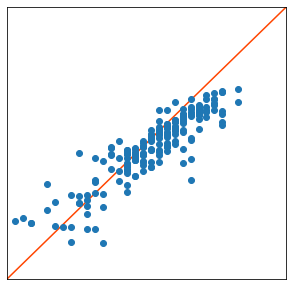

100%|██████████| 200/200 [00:00<00:00, 394.38it/s]


X_R^2:0.41912899286151495


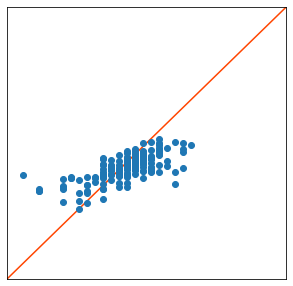

100%|██████████| 200/200 [00:00<00:00, 383.00it/s]


Y_R^2:0.7386281486566384


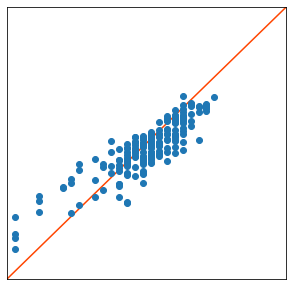

100%|██████████| 200/200 [00:00<00:00, 393.71it/s]


Z_R^2:0.5740578456583056


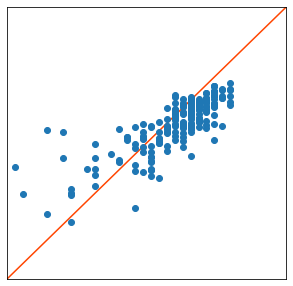

<built-in function max>


In [26]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
df = test(model, device)

In [27]:
pd.set_option('display.max_columns', 100)
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
R^2,0.750602,0.537047,0.581287,0.70775,0.317469,0.618879,0.441593,0.582448,0.634478,0.571289,0.627601,0.630445,0.514562,0.602088,0.430435,0.625419,0.810923,0.593312,0.482665,0.74966,0.548614,0.419138,0.747131,0.419129,0.738628,0.574058
